esm based dynamic model (not using static embeds).

+ Use HF Trainer, LORA:
  * https://huggingface.co/blog/AmelieSchreiber/esmbind

Use TF:
*  🇰https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling-tf.ipynb#scrollTo=de8419b5
* Torch based /Trainer example:  https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb#scrollTo=49dcba23



* NOte for pytorch training could use trainer maybe, and mixed precision - https://huggingface.co/docs/transformers/v4.18.0/en/performance#fp16-training


* QLORA finetuning: https://huggingface.co/blog/AmelieSchreiber/esm2-ptm
  * https://huggingface.co/blog/AmelieSchreiber/esmbind   (token level)

* Another lora, qlora example - may use too much mem/bug : https://github.com/huggingface/peft/issues/1023
* Default trainer (`AutoModelForSequenceClassification`) + Lora https://huggingface.co/docs/peft/task_guides/image_classification_lora
   * seq cls with lora - maybe `task_type="SEQ_CLS"` ? https://github.com/huggingface/peft/blob/main/docs/source/task_guides/ptuning-seq-classification.md
* https://www.kaggle.com/code/andregrbnr/protein-sequence-classification - lora modules to save ??

  * ESM2-Lora mem bug (also accel data loop) ? https://github.com/huggingface/peft/issues/1023


* QLORA: https://huggingface.co/blog/AmelieSchreiber/esm2-ptm
  * `36 batch size` with esm-150M !

* lora peft - classifier layer weight saving issue?  https://github.com/huggingface/peft/issues/577

https://github.com/huggingface/transformers/issues/27702

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !conda install -c conda-forge google-colab -y

# !pip install tensorflow  -U -q # ankh

# !pip install torch  -U -q # fair-esm # seqeval
# !pip3 install transformers peft accelerate datasets evaluate bitsandbytes -U -q # --user
# !pip install peft bitsandbytes -U

* Use the unirpot fasta file I downloaded and uploaded to my drive

`/content/drive/MyDrive/Research/biodata/proteins/Transmembrane_human_90.fasta`

* Download fasta from: `https://www.uniprot.org/uniref/?query=uniprot:(keyword%3A%22Transmembrane+%5BKW-0812%5D%22+AND+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22)+identity:0.9`

In [3]:
#### DATA_PATH = "/content/drive/MyDrive/Research/CIDR-Protein Anomalies project/protein_anomalies_data/swp_human_viri_all_embed_esm.parquet" ## ESM1B embedding (max len 1022)
# DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/hum_vir_swp-globalEmbed-train.csv.gz"## TRAIN
# DATA_PATH = "/content/drive/MyDrive/hum_vir_swp-globalEmbed-train.csv.gz"
# DATA_PATH = "/kaggle/input/humvir-proteins/hum_vir_swp-globalEmbed-train.csv/hum_vir_swp-globalEmbed-train.csv"
DATA_PATH = "hum_vir_swp-globalEmbed-train.csv.gz"

## TEST data:
# TEST_DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/hum_vir_swp-globalEmbed-test.csv.gz"## TRAIN
# TEST_DATA_PATH = "/content/drive/MyDrive/hum_vir_swp-globalEmbed-test.csv.gz"
# TEST_DATA_PATH = "/kaggle/input/humvir-proteins/hum_vir_swp-globalEmbed-test.csv/hum_vir_swp-globalEmbed-test.csv"
TEST_DATA_PATH = "hum_vir_swp-globalEmbed-test.csv.gz"

# ## metadata for all reviewed/swissprot human + virus proteins
# METADATA_PATH = "/content/drive/MyDrive/Research/CIDR-Protein Anomalies project/protein_anomalies_data/SWP_human_viruses_all.xlsx"

TARGET_COL = "virus" ## use for filtering data into 1 class

MAX_LEN = 768#1024#768#530 # exclude sequences longer than this. (Not merely truncate)

FAST_RUN = True
SAVE_MODEL = True#False#True


# MODEL_DRIVE_SAVE_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/trained_esm_lora_trainer_model"
MODEL_DRIVE_SAVE_PATH = "150_esm_lora_trainer_model"
# MODEL_DRIVE_SAVE_PATH = "/kaggle/input/humvir-proteins/qlora/qlora" # saved + reuploadedon kaggle

TRAIN_MODEL = True#False
LOAD_TRAINED =  True#False# True

In [4]:
# MY_FASTA_PATH = "/content/drive/MyDrive/Research/biodata/proteins/Transmembrane_human_90.fasta" # 14k sequences, with fragments, 90% id redundnancy

# MY_FASTA_PATH = "/content/drive/MyDrive/Research/biodata/proteins/Transmembrane_human_whole_100.fasta" # 30K sequences, without fragments
# MY_FASTA_PATH = "Transmembrane_human_whole_90.fasta"

# Embed sequences in a FASTA file

In [5]:
# from bio_embeddings.embed import ProtTransBertBFDEmbedder
# from Bio import SeqIO
import torch
# import esm
import tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
import random
# from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
from sklearn.preprocessing  import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict
# from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
# from sklearn.ensemble import HistGradientBoostingClassifier
from tqdm.autonotebook import tqdm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score

from transformers import TrainingArguments, Trainer, logging
from accelerate import Accelerator
from torch.utils.data.dataloader import DataLoader
## https://huggingface.co/docs/transformers/perf_train_gpu_one

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AdamWeightDecay
# from tensorflow.keras.optimizers import Adafactor, Adam # more memory effecient than adamWD
# import tensorflow
# from tensorflow.keras.metrics.AUC()
# from transformers import AutoTokenizer #DataCollatorForLanguageModeling,
## https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example
from transformers import AutoTokenizer, EsmForSequenceClassification, Trainer
from transformers import TFAutoModelForSequenceClassification ,TFEsmForSequenceClassification
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, BitsAndBytesConfig
from peft import AutoPeftModelForSequenceClassification, AutoPeftModel

## could use transformer pipeline for inference;
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
# pipe = pipeline("text-classification", model="facebook/wav2vec2-base-960h", device=0)

2024-02-14 21:17:01.591015: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-14 21:17:01.612514: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 21:17:01.612542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 21:17:01.613156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 21:17:01.616709: I tensorflow/core/platform/cpu_feature_guar

In [6]:
import wandb
wandb.init(mode="disabled")
# alt 
# wandb.init(project='qlora_humvir')# ; or args = TrainingArguments(report_to="none")

In [7]:
from accelerate import Accelerator
# # Use the accelerator
# ### try disabling? (with qlora)
# # accelerator = Accelerator()# trying this
# # שבבקךקרשאםר צשטנק בשודקד ןדדוקד?
accelerator = Accelerator(mixed_precision="fp16") #bf16") # fp16 # orig used

In [8]:
num_epochs = 3#4
bch_size = 16#36#32#8#3#2

# opt = Adafactor(3e-4)##AdamWeightDecay(1e-4) #default: AdamWeightDecay(2e-5)
# opt = AdamWeightDecay(5e-4)#(1e-3)
# opt = Adam(8e-4)

if FAST_RUN:
    num_epochs = 2
    # bch_size = 16
    bch_size = 32#32
    MAX_LEN = int(MAX_LEN//1.3)

In [9]:
# model_checkpoint ="facebook/esm2_t6_8M_UR50D"
# model_checkpoint =  "facebook/esm2_t12_35M_UR50D"
model_checkpoint =  "facebook/esm2_t30_150M_UR50D"
# model_checkpoint =  "facebook/esm2_t33_650M_UR50D"

if FAST_RUN:
    # model_checkpoint ="facebook/esm2_t6_8M_UR50D"
  model_checkpoint =  "facebook/esm2_t12_35M_UR50D"


In [10]:
# df = pd.read_parquet(DATA_PATH) # numpy to pandas
df = pd.read_csv(DATA_PATH,usecols=["Sequence","virus","Length","Cluster name"])
df_test = pd.read_csv(TEST_DATA_PATH,usecols=["Sequence","virus","Length",	"Cluster name"])
 ## lengths of all the seqs

if FAST_RUN:
#   # df.loc[df["Length"]>100]
    df = df.sample(frac=0.1,random_state=4)
    df_test = df_test.sample(frac=0.35,random_state=4)
df

,Sequence,virus,Length,Cluster name
0,MADFLKGLPVYNKSNFSRFHADSVCKASNRRPSVYLPTREYPSEQI...,0,102,Cluster: DET1- and DDB1-associated protein 1
1,MPSTLQVLAKKVLALEHKENDHISREYYYHILKCCGLWWHEAPIIL...,1,362,Cluster: Protein MGF 360-19R
2,MASSAELDFNLQALLEQLSQDELSKFKSLIRTISLGKELQTVPQTE...,0,97,Cluster: Pyrin domain-containing protein 2
3,MAAWGKKHAGKDPVRDECEERNRFTETREEDVTDEHGEREPFAETD...,0,186,Cluster: Protein FAM9B
4,MASDSPARSLDEIDLSALRDPAGIFELVELVGNGTYGQVYKGRHVK...,0,1360,Cluster: TRAF2 and NCK-interacting protein kinase
...,...,...,...,...
20335,MDPDKQDALNSIENSIYRTAFKLQSVQTLCQLDLIDSSLIQQVLLR...,0,578,Cluster: Dystrotelin
20336,MLCPWRTANLGLLLILTIFLVAEAEGAAQPNNSLMLQTSKENHALA...,0,348,Cluster: Cell surface glycoprotein CD200 recep...
20337,MCLRFFSPVPGSTSSATNVTMVVSAGPWSSEKAEMNILEINEKLRP...,0,421,Cluster: Putative neuroblastoma breakpoint fam...
20338,MASHAGQQHAPAFGQAARASGPTDGRAASRPSHRQGASEARGDPEL...,1,376,Cluster: Thymidine kinase


In [11]:
df.groupby(["virus"])["Length"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
virus,,,,,,,,
0,14668.0,473.16,308.52,11.0,244.0,398.0,623.0,1533.0
1,5672.0,380.31,298.35,11.0,151.0,297.0,514.0,1520.0


In [12]:
print(df["virus"].agg(["mean","sum","count"]).round(2))
df["Length"].describe().round(0)

mean         0.28
sum       5672.00
count    20340.00
Name: virus, dtype: float64


count    20340.0
mean       447.0
std        309.0
min         11.0
25%        213.0
50%        372.0
75%        592.0
max       1533.0
Name: Length, dtype: float64

In [13]:
df_test["Length"].describe().round(1)

count    4777.0
mean      444.3
std       304.5
min        18.0
25%       212.0
50%       369.0
75%       589.0
max      1534.0
Name: Length, dtype: float64

In [14]:
# df = df.loc[df["Length"]<=2*MAX_LEN].reset_index(drop=True)
# df_test = df_test.loc[df_test["Length"]<=2*MAX_LEN].reset_index(drop=True)

print(df["Length"].describe().round(1))
print(df["virus"].agg(["mean","sum","count"]).round(2))

count    20340.0
mean       447.3
std        308.5
min         11.0
25%        213.0
50%        372.0
75%        592.2
max       1533.0
Name: Length, dtype: float64
mean         0.28
sum       5672.00
count    20340.00
Name: virus, dtype: float64


In [15]:
# ## metadata about all sequences, can be used to identify and to define targets/labels
# df_meta = pd.read_excel(METADATA_PATH).dropna(how="all",axis=1)
# df_meta

### example pretrained fb/torch:
* https://github.com/facebookresearch/esm#getting-started-with-this-repo-

* Transformers + trainer example : (mlm case): https://github.com/facebookresearch/esm/discussions/556
* keras models supported / via HF?
  * https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example


  TF finetuning example (sequence evel?):
  https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling-tf.ipynb#scrollTo=4b26b828

In [16]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers import Adafactor, Adam # more memory effecient than adamWD
import tensorflow
# from tensorflow.keras.metrics.AUC()
# from transformers import AutoTokenizer #DataCollatorForLanguageModeling,
## https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example
from transformers import AutoTokenizer, EsmForSequenceClassification, Trainer
from transformers import TFAutoModelForTokenClassification, TFAutoModelForSequenceClassification ,TFEsmForSequenceClassification

from peft import prepare_model_for_kbit_training, get_peft_model

In [17]:
ID2LABEL = {
    0: "Human",
    1: "Virus"
}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

In [18]:
train_sequences = df["Sequence"].tolist()
train_labels = df["virus"].tolist()
train_groups = df["Cluster name"].tolist()

# train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.25, shuffle=True)#,stratify=labels)

test_sequences = df_test["Sequence"].tolist()
test_labels = df_test["virus"].tolist()

In [19]:
# !pip3 install bitsandbytes peft -U
 
# !pip install bitsandbytes transformers peft --upgrade --force-reinstall

In [20]:
##https://huggingface.co/docs/peft/main/en/developer_guides/quantization
## lotfQ config - for this, do not initialize as quantized!
# from peft import LoftQConfig, LoraConfig, get_peft_model
# loftq_config = LoftQConfig(loftq_bits=4)

## https://huggingface.co/blog/4bit-transformers-bitsandbytes
# compute_dtype = getattr(torch, "float16")
compute_dtype = getattr(torch, "bfloat16")

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True, # disable to train ok;
  # load_in_8bit=True, # alt
  bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
    # bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_has_fp16_weight =True,
    llm_int8_threshold = 5.1,
   bnb_4bit_compute_dtype=compute_dtype #torch.bfloat16
    ,llm_int8_skip_modules=['classifier',"EsmClassificationHead"] # was enabled? 
)

# ### https://huggingface.co/blog/AmelieSchreiber/esm2-ptm
# nf4_config = BitsAndBytesConfig(
#     # load_in_4bit=True,
#     # bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
#     # bnb_4bit_compute_dtype = torch.float16#"float16"
# )

#########################

# Load ESM-2 model
## smallest: esm2_t6_8M_UR50D
## 2d smallest
## large: esm2_t33_650M_UR50D

 # ElnaggarLab/ankh-base
 ### https://github.com/agemagician/Ankh/blob/main/examples/binary_classification_solubility_task.ipynb - different model?
 #  https://github.com/agemagician/Ankh#models   - 450M model size # model_checkpoint =   "ElnaggarLab/ankh-base"

model_max_len = min(1024,MAX_LEN) # 800

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                          padding= False#True # orig
#                                           padding= True# alt
                                          ,truncation=True,max_length=model_max_len)

num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
print("Num labels:", num_labels)
##ORIG:
# model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification") # worked, orig

## try this now, alt:
# model = EsmForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
# model = TFEsmForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")

## https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb#scrollTo=fc164b49 # uses trainer
##

# model = AutoModelForSequenceClassification. # orig
# model = EsmForSequenceClassification.
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           problem_type="single_label_classification", # was enabled
                                                           # load_in_4bit=True, # disable to train ok
                                                            quantization_config=nf4_config,
                                                          #  load_in_8bit=True,  torch_dtype=torch.float32, # try this - new
                                                           # device_map= "cuda:0",#"auto",
                                                           device_map="auto",
                                                          num_labels=len(ID2LABEL), id2label=ID2LABEL, label2id=LABEL2ID,
                                                            # trust_remote_code=True
                                                           # , from_tf=True,
                                                           # force_download =True,
                                                          )

# last_layer_num = model.num_layers ## 33 for esm2_t33_650M_UR50D
# print(last_layer_num )
model.train()
# model.print_trainable_parameters()

Num labels: 2


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear4bit(in_features=640, out_features=640, bias=True)
              (key): Linear4bit(in_features=640, out_features=640, bias=True)
              (value): Linear4bit(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear4bit(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm(

In [21]:
# model.print_trainable_parameters()

In [22]:
model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=False) # prepares the whole model for kbit training

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True) # prepares the whole model for kbit training
print(model)
# #### model.enable_input_require_grads()

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear4bit(in_features=640, out_features=640, bias=True)
              (key): Linear4bit(in_features=640, out_features=640, bias=True)
              (value): Linear4bit(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear4bit(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm(

In [23]:
# ## https://github.com/huggingface/transformers/issues/27702

# for name, param in model.named_parameters():
#     # # Freeze all parameters
#     if param.dtype in [torch.float16, torch.float32, torch.float64]:
#     #     param.requires_grad = False

#         # Unfreeze the last two layers in 'layers' and 'score'
#         # if name.startswith('model.layers') and (int(name.split('.')[2]) >= 30):
#         #     param.requires_grad = True
#         # elif name.startswith('score'):
#         #     param.requires_grad = True
#         if name.startswith('class'):
#             print(name,param.requires_grad)
#             param.requires_grad = True

In [24]:
from torch import nn
target_modules_allin = [name for name, layer in model.named_modules() if isinstance(layer, nn.Linear)]
print(target_modules_allin)

modules_list = [
            "position_embeddings", # alt new
            "query",
            "key",
            "value",
            "EsmSelfOutput.dense",
            "EsmIntermediate.dense",
            "EsmOutput.dense",
            "EsmContactPredictionHead.regression",
            # "classifier",
            "EsmClassificationHead.dense",
             "EsmClassificationHead.out_proj",
            ## try adding? :
            "classifier.dense", "classifier.out_proj", # new
#             'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight' # was used
        ]

target_modules=[
            "query",
            "key",
            "value",
            "EsmSelfOutput.dense",
            "EsmIntermediate.dense",
            "EsmOutput.dense",
            # "EsmContactPredictionHead.regression",
            # "classifier"
        ],


['esm.encoder.layer.0.attention.self.query', 'esm.encoder.layer.0.attention.self.key', 'esm.encoder.layer.0.attention.self.value', 'esm.encoder.layer.0.attention.output.dense', 'esm.encoder.layer.0.intermediate.dense', 'esm.encoder.layer.0.output.dense', 'esm.encoder.layer.1.attention.self.query', 'esm.encoder.layer.1.attention.self.key', 'esm.encoder.layer.1.attention.self.value', 'esm.encoder.layer.1.attention.output.dense', 'esm.encoder.layer.1.intermediate.dense', 'esm.encoder.layer.1.output.dense', 'esm.encoder.layer.2.attention.self.query', 'esm.encoder.layer.2.attention.self.key', 'esm.encoder.layer.2.attention.self.value', 'esm.encoder.layer.2.attention.output.dense', 'esm.encoder.layer.2.intermediate.dense', 'esm.encoder.layer.2.output.dense', 'esm.encoder.layer.3.attention.self.query', 'esm.encoder.layer.3.attention.self.key', 'esm.encoder.layer.3.attention.self.value', 'esm.encoder.layer.3.attention.output.dense', 'esm.encoder.layer.3.intermediate.dense', 'esm.encoder.layer.

In [25]:
import bitsandbytes as bnb
def find_all_linear_names(model):
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, bnb.nn.Linear4bit):
            names = name.split(".")
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if "lm_head" in lora_module_names:  # needed for 16-bit
        lora_module_names.remove("lm_head")
    return list(lora_module_names)


my_lin_layers = find_all_linear_names(model)
print(my_lin_layers)

['value', 'regression', 'dense', 'query', 'key']


"After we wrap our base model model with PeftModel along with the config, we get a new model where only the LoRA parameters are trainable (so-called “update matrices”) while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify modules_to_save. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like save_pretrained() and push_to_hub().

In addition to specifying the target_modules within LoraConfig, we also need to specify the modules_to_save. When we wrap our base model with PeftModel and pass the configuration, we obtain a new model in which only the LoRA parameters are trainable, while the pre-trained parameters and the randomly initialized classifier parameters are kept frozen. However, we do want to train the classifier parameters. By specifying the modules_to_save argument, we ensure that the classifier parameters are also trainable, and they will be serialized alongside the LoRA trainable parameters when we use utility functions like save_pretrained() and push_to_hub()."

* `task_type= "SEQ_CLS"` - breaks - RuntimeError: only Tensors of floating point dtype can require gradients

In [26]:
## https://huggingface.co/blog/AmelieSchreiber/esmbind
# https://huggingface.co/docs/peft/task_guides/token-classification-lora
### target modules?? https://discuss.huggingface.co/t/esm-2-qlora-gradient-checkpointing-not-compatible/53505/2
## could also set to all linear? 

### https://huggingface.co/docs/peft/task_guides/semantic_segmentation_lora#wrap-the-base-model-as-a-peftmodel-for-lora-training

peft_config = LoraConfig(base_model_name_or_path=model_checkpoint,
#                         init_lora_weights="loftq", loftq_config=loftq_config,
    task_type= "SEQ_CLS",#TaskType.SEQ_CLS, ## disabling helps?? (then get "ValueError: Attempting to unscale FP16 gradients.")
    inference_mode=False, r= 2 if FAST_RUN else 8, #16,
    lora_alpha=8,
    # lora_dropout=0.1,
    use_rslora = True,
    # bias= "none",#"lora_only",#"none",#"all",
    # bias="all", #"lora_only",
    bias="lora_only",
    # target_modules=my_lin_layers,
    #                      [
    #     "query", "key", "value",
    #     "dense",
    # # "out_proj"
    # ]
    #                 "EsmSelfOutput.dense",
    #         "EsmIntermediate.dense",
    #         "EsmOutput.dense",
    #                 # "word_embeddings",
    #                 # "EsmClassificationHead.dense", ## not sure if works/changes anything
    #                 # "out_proj",
    #                 # "classifier" # fails
    #                 ],
        # target_modules=  target_modules#"all-linear"#modules_list,
           target_modules=  "all-linear"
                     # target_modules=     target_modules_allin
                         
    # # ### https://www.kaggle.com/code/andregrbnr/protein-sequence-classification
     # ,modules_to_save= # "all-linear",
      # ,modules_to_save=  [ 'classifier.dense', 'classifier.out_proj'],
#                       # "classifier",
         # ,modules_to_save= ["EsmClassificationHead"]
      
# #          "pooler",
# # # #                      'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight'
                     # ]
    ## 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight'
    # ,modules_to_save=["classifier"]
                         # ,modules_to_save=[ 'classifier.dense', 'classifier.out_proj']
)

get_peft_model(model, peft_config)

# model = get_peft_model(model, peft_config,mixed=True) # mixed prevents peft save, but othewise, 8bit error?
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 3,196,506 || all params: 152,008,645 || trainable%: 2.10284487438198


In [27]:
print(model)
# get_peft_model(model, peft_config)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 640, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 640, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-29): 30 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=640, out_features=640, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=640, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                     

In [28]:
# # # ## redo here?
# model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model) # prepares the whole model for kbit training
# # print(model)

In [29]:
## Warning - longer than allowed length - 1024
train_tokenized = tokenizer( train_sequences,  truncation=True,max_length=model_max_len,padding=False) # padding=True,
test_tokenized = tokenizer(test_sequences,  truncation=True,max_length=model_max_len,padding=False) # padding=True,

In [30]:
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 20340
})

In [31]:
# from accelerate import Accelerator
# # # Use the accelerator
# # ### try disabling? (with qlora)
# # accelerator = Accelerator()# trying this
# # # # accelerator = Accelerator(mixed_precision="fp16") # fp16 # orig used
# model = accelerator.prepare(model)

# train_dataset = accelerator.prepare(train_dataset)
# test_dataset = accelerator.prepare(test_dataset)

In [32]:
# print(set(model.hf_device_map.values()))

With 35M model :
```
Default (1024) max length
batch_size=8

opt = Adafactor(1e-4)##AdamWeightDecay(1e-4) #default: AdamWeightDecay(2e-5)
model.compile(optimizer=opt, metrics=["accuracy"],
              loss="BinaryCrossentropy")
3813/3813 [==============================] - 2625s 661ms/step - loss: 0.2452 - accuracy: 0.9104 - val_loss: 0.1622 - val_accuracy: 0.9363
Epoch 2/3
3813/3813 [==============================] - 2518s 661ms/step - loss: 0.1218 - accuracy: 0.9597 - val_loss: 0.1533 - val_accuracy: 0.9463
Epoch 3/3
3813/3813 [==============================] - 2523s 662ms/step - loss: 0.0730 - accuracy: 0.9799 - val_loss: 0.1978 - val_accuracy: 0.9436

```

In [33]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,roc_auc_score
import evaluate

from datasets import load_metric
import torch._dynamo
torch._dynamo.config.suppress_errors = True
    
metric_acc = evaluate.load("accuracy")

metric = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        # 'f1': f1,
        # 'precision': precision,
        # 'recall': recall,
        "roc_auc":roc_auc_score(labels,pred.predictions[:,1])
    }

In [34]:
# ### AttributeError: 'TFEsmForSequenceClassification' object has no attribute 'to'
model_name = model_checkpoint.split("/")[-1]
print(model_name)

training_args = TrainingArguments(
    f"{model_name}-finetuned-ft-humVir",
    # f"/content/drive/MyDrive/proteins/New Protein-Virus anom project/t{model_name}-finetuned-humVir",
    per_device_train_batch_size=bch_size,
    # per_device_eval_batch_size=int(1.5*bch_size),
#     gradient_accumulation_steps= 2, #4,
    gradient_checkpointing=True,
    # fp16=True,
    bf16=True, # needs ampere, not supported ?
    tf32=True,
        # torch_compile = True,
    optim = "adamw_8bit", #"paged_adamw_8bit", # adamw_bnb_8bit
    # optim= "adamw_bnb_8bit", #"paged_adamw_8bit",
    label_names = ["labels"],
    learning_rate = 5e-4#2e-4 #5e-3,
    # lr_scheduler_type="cosine",
    ,max_grad_norm = 0.95,
#     weight_decay=0.002,
    # eval_accumulation_steps = 2#8
    evaluation_strategy="epoch",
    # warmup_ratio=0.02,
    save_strategy= "epoch",#"no",
    # output_dir=".",
     no_cuda=False,
     greater_is_better=True,
     # save_total_limit=1,
  remove_unused_columns=False,
    auto_find_batch_size = True, # new , reduces if oom
    num_train_epochs=num_epochs,
    load_best_model_at_end=True,
    metric_for_best_model= "roc_auc",#"accuracy",
    group_by_length=True,
)

trainer = Trainer(model=model, args=training_args,
                  train_dataset=train_dataset,eval_dataset=test_dataset,tokenizer=tokenizer,
                  compute_metrics=compute_metrics,)

esm2_t30_150M_UR50D


In [35]:
if TRAIN_MODEL:
    result = trainer.train()

/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.123900,0.122016,0.956458,0.989431
2,0.042900,0.091597,0.969646,0.993354


/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [36]:
trainer.evaluate()

{'eval_loss': 0.09159661084413528,
 'eval_accuracy': 0.969646221477915,
 'eval_roc_auc': 0.9933538461538461,
 'eval_runtime': 134.7247,
 'eval_samples_per_second': 35.457,
 'eval_steps_per_second': 4.439,
 'epoch': 2.0}

In [37]:
MODEL_DRIVE_SAVE_PATH

'small_trained_esm_lora_trainer_model'

In [38]:
# print(trainer.model)

In [39]:
if TRAIN_MODEL:    
    if SAVE_MODEL:
      # trainer.model.merge_and_unload() # merges the adapter layers into the base model. (vs saving just adapter part?)
      if FAST_RUN:
        # trainer.save_model("/content/drive/MyDrive/proteins/New Protein-Virus anom project/mini_trained_esm_qlora_trainer_model")
        trainer.model.save_pretrained(MODEL_DRIVE_SAVE_PATH) #. PEFT friendly
      else:
        # trainer.save_model(MODEL_DRIVE_SAVE_PATH)
        trainer.model.save_pretrained(MODEL_DRIVE_SAVE_PATH) #. PEFT friendly

In [40]:
if TRAIN_MODEL:
    
    try: trainer.model.eval()
    except:()

### load model for **comparison**
* , untrained model ?
*  https://huggingface.co/blog/AmelieSchreiber/esmbind

In [41]:
model_checkpoint

'facebook/esm2_t30_150M_UR50D'

In [42]:
### https://huggingface.co/blog/AmelieSchreiber/esmbind
# # Path to the saved LoRA model
# model_path = "AmelieSchreiber/esm2_t12_35M_lora_binding_sites_v2_cp3"
# # ESM2 base model
# base_model_path = "facebook/esm2_t12_35M_UR50D"

base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")
base_model.eval()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=640, out_features=640, bias=True)
              (key): Linear(in_features=640, out_features=640, bias=True)
              (value): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((640,), eps=1e-0

In [43]:
if FAST_RUN:
  print(Trainer(model=base_model, args=training_args,
                  train_dataset=train_dataset,eval_dataset=test_dataset,tokenizer=tokenizer,
                  compute_metrics=compute_metrics,).evaluate()) # worse than trained model - OK!

In [44]:
MODEL_DRIVE_SAVE_PATH

'small_trained_esm_lora_trainer_model'

In [45]:
###
### it says it is not loading saved classifier weights?? but trainer pred gives ok results (better than with random model)? 
from peft import PeftModelForSequenceClassification, get_peft_config
if LOAD_TRAINED:
    """
    base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")
    """
#   ### load pretrained, trained model?

    # trained_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=num_labels,problem_type="single_label_classification")
    # print("loading PEFT config")

    # trained_model = PeftModelForSequenceClassification.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH,
    #                                                                    config=peft_config) # alt
    
    trained_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DRIVE_SAVE_PATH,
                                                                  num_labels=num_labels,problem_type="single_label_classification") 
    trained_model = PeftModel.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH)
    ## 
#     trained_model = prepare_model_for_kbit_training(trained_model, use_gradient_checkpointing=True)
    
else:
    trained_model = trainer.model
trained_model.eval()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading adapter weights from small_trained_esm_lora_trainer_model led to unexpected keys not found in the model:  ['classifier.modules_to_save.dense.lora_A.default.weight', 'classifier.modules_to_save.dense.lora_B.default.weight', 'classifier.modules_to_save.out_proj.lora_A.default.weight', 'classifier.modules_to_save.out_proj.lora_B.default.weight', 'classifier.original_module.dense.lora_A.default.weight', 'classifier.original_module.dense.lora_B.default.weight', 'classifier.original_module.out_proj.lora_A.default.weight', 'classifier.original_module.out_proj.lora_B.default.weight']. 


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 640, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 640, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-29): 30 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=640, out_features=640, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=640, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (defaul

In [46]:
## check if saved loaded ok?
if FAST_RUN:
  print(Trainer(model=trained_model, args=training_args,tokenizer=tokenizer,
                    train_dataset=train_dataset,eval_dataset=test_dataset,
                    compute_metrics=compute_metrics,).evaluate()) ## only ok if better than random init

In [47]:
if FAST_RUN:
  print(trainer.evaluate())

In [48]:
# from transformers import pipeline

# tok.add_special_tokens({'pad_token': '[PAD]'})

# classifier = pipeline("zero-shot-classification", model=m, tokenizer=tok)

# classifier("Today was an amazing day", candidate_labels=["negative", "positive"])

* Cao - maybe use only RBD domain ,  (+- mutation site?)


* Could get WT prediction, and get **delta** of mutant's predicted score vs wt - then examine that.



* https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example


* Eval related batch size stuff: https://discuss.huggingface.co/t/batch-size-for-trainer-predict/3374/2

In [49]:
# CAO_TEST_DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/cao_escaper_targets_max.csv"##
# CAO_TEST_DATA_PATH = "/kaggle/input/humvir-proteins/cao_escaper_targets_max.csv"
CAO_TEST_DATA_PATH = "cao_escaper_targets_max.csv"

### all data, more redundnat - same seq repeated, can join with our res to save time.
# CAO_full_TEST_DATA_PATH = "/kaggle/input/humvir-proteins/cao_escaper_targets_all.csv"
CAO_full_TEST_DATA_PATH = "cao_escaper_targets_all.csv.gz"

In [50]:
df_cao = pd.read_csv(CAO_TEST_DATA_PATH)
# if FAST_RUN:
#   df_cao = df_cao.head(100)

df_cao_full = pd.read_csv(CAO_full_TEST_DATA_PATH)
print(df_cao_full["seq"].nunique())
print(df_cao_full["seq"].str.len())
display(df_cao_full)

3820


,site,wildtype,mutation,mut_escape,seq,mut_escape_class
0,331,N,A,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
1,331,N,C,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
2,331,N,D,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
3,331,N,E,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
4,331,N,F,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
...,...,...,...,...,...,...
34673,489,Y,R,0.001041,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34674,489,Y,S,0.185581,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34675,489,Y,T,0.088192,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34676,489,Y,V,0.014363,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1


In [51]:
from scipy.special import softmax

def get_escaper_scores(df:pd.DataFrame,trained_model,base_model,seqColName="seq",truncate_cao=False,
                       binary_target_col = None):
  if truncate_cao:
  ## truncated version +-20:
    cao_sequences = df[seqColName].str[300:550].tolist() # ONLY RBD domain
    max_len = 550-300
  else:
    cao_sequences = df[seqColName].tolist()
    max_len = df[seqColName].str.len().max()+2

  cao_test_seq = tokenizer(cao_sequences,  truncation=True
                          ,max_length= min(max_len,1024)#1024
                        #  max_length= 700 #600 #model_max_len,
                         # ,padding=False#True,
                           ,padding=True
                           ,return_tensors="pt")

  cao_test_seq = Dataset.from_dict(cao_test_seq)
  # cao_test_seq = accelerator.prepare(cao_test_seq)
    ## get naive models preds - WHY are they similar to trained models ???
  # """
  base_trainer = Trainer(base_model,tokenizer=tokenizer,args=training_args)
  raw_pred, _, _ = base_trainer.predict(cao_test_seq)
  # predictedLabelOnCompanyData = np.argmax(raw_pred, axis=1)
  # df["base_pred_vir"] = raw_pred[:,1]
  df["base_pred_vir"] = torch.nn.functional.softmax(torch.tensor(raw_pred), dim=1)[:,1]
  # """
    
  ## preds with proper model
  trainer = Trainer(model=trained_model,tokenizer=tokenizer,args=training_args) # added here...
    ### https://discuss.huggingface.co/t/transform-logits-to-probabilities-doesnt-work/14792
  logits, _, _ = trainer.predict(cao_test_seq)

  # print(softmax(logits[:,1]))
  # df["probabilities"] = softmax(logits[:,1]) #(preds_output[0], axis=1)#probabilities
    
  # df["model_pred_vir"] =  logits[:,1]
  # df["model_pred_hum"] = softmax(logits, axis=0) #softmax(logits[:,0])
  # df["model_pred_vir"] =  softmax(logits[:,1])
  df["model_pred_vir"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]
  df["model_pred_hum"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,0]
  # df["sum"] = (df["model_pred_hum"]+df["model_pred_vir"]).round(2) # adds up to 1
  df["model_pred_hum_delta"] = df["model_pred_hum"].round(4)

  ## subtract WT pred score - to get deltas. WT is most common (as it reoccurs)
  mode_score = df["model_pred_hum"].round(4).mode()[0]
  df["model_pred_hum_delta"] = df["model_pred_hum_delta"] - mode_score
  print(df.describe().round(3))

  display(df.select_dtypes(["number","bool"]).corr().round(3))

  if binary_target_col is not None:
    print("humVir trained model - human pred delta - ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum_delta"]).round(4))
    print("humVir trained model ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum"]).round(4))
    print(classification_report(df[binary_target_col],np.argmax(logits, axis=-1)))
    print("Untrained vir model: ROCAUC",roc_auc_score(df[binary_target_col], df["base_pred_vir"]).round(4))

  return df

# get_escaper_scores(df_iedb_vir.sample(16).copy(),trained_model=model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)


In [52]:
# df_cao["seq"] = df_cao["seq"].str[0:MAX_LEN+100]
df_cao

,site,wildtype,mutation,mut_escape,mut_escape_class,seq
0,331,N,A,0.009428,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1,331,N,C,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
2,331,N,D,0.026596,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,331,N,E,0.112258,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4,331,N,F,0.012256,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
...,...,...,...,...,...,...
4015,531,T,S,0.010178,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4016,531,T,T,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4017,531,T,V,0.009521,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4018,531,T,W,0.008336,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [53]:
# # model.eval()
# ## truncated version +-20:
# cao_sequences = df_cao["seq"].str[300:550].tolist() # ONLY RBD domain
# # cao_sequences = df_cao["seq"].tolist()

# ## ALT:
# cao_sequences = df_cao["seq"].str[0:550].tolist()

In [54]:
df_cao_preds = get_escaper_scores(df_cao.copy(),trained_model=trainer.model,
                   base_model=base_model,seqColName="seq",truncate_cao=True,
                       binary_target_col = "mut_escape_class")

          site  mut_escape  mut_escape_class  base_pred_vir  model_pred_vir  \
count  4020.00    4020.000          4020.000       4020.000          4020.0   
mean    431.00       0.197             0.528          0.495             1.0   
std      58.03       0.335             0.499          0.001             0.0   
min     331.00       0.000             0.000          0.491             1.0   
25%     381.00       0.000             0.000          0.494             1.0   
50%     431.00       0.007             1.000          0.495             1.0   
75%     481.00       0.305             1.000          0.496             1.0   
max     531.00       3.602             1.000          0.501             1.0   

       model_pred_hum  model_pred_hum_delta  
count          4020.0                4020.0  
mean              0.0                   0.0  
std               0.0                   0.0  
min               0.0                   0.0  
25%               0.0                   0.0  
50%         

,site,mut_escape,mut_escape_class,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
site,1.000,0.073,0.093,-0.294,0.235,-0.235,-0.050
mut_escape,0.073,1.000,0.555,0.002,0.061,-0.061,-0.026
mut_escape_class,0.093,0.555,1.000,0.035,0.043,-0.042,-0.046
base_pred_vir,-0.294,0.002,0.035,1.000,-0.182,0.182,0.032
model_pred_vir,0.235,0.061,0.043,-0.182,1.000,-1.000,-0.244
model_pred_hum,-0.235,-0.061,-0.042,0.182,-1.000,1.000,0.244
model_pred_hum_delta,-0.050,-0.026,-0.046,0.032,-0.244,0.244,1.000


humVir trained model - human pred delta - ROCAUC: 0.4976
humVir trained model ROCAUC: 0.4781
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1897
           1       0.53      1.00      0.69      2123

    accuracy                           0.53      4020
   macro avg       0.26      0.50      0.35      4020
weighted avg       0.28      0.53      0.37      4020

Untrained vir model: ROCAUC 0.5238


/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [55]:
0.4821+0.5147

0.9968

In [56]:
## mode without save + load
get_escaper_scores(df_cao,trained_model=model, #trainer,
                   base_model=base_model,seqColName="seq",truncate_cao=True,
                       binary_target_col = "mut_escape_class")

          site  mut_escape  mut_escape_class  base_pred_vir  model_pred_vir  \
count  4020.00    4020.000          4020.000       4020.000          4020.0   
mean    431.00       0.197             0.528          0.495             1.0   
std      58.03       0.335             0.499          0.001             0.0   
min     331.00       0.000             0.000          0.491             1.0   
25%     381.00       0.000             0.000          0.494             1.0   
50%     431.00       0.007             1.000          0.495             1.0   
75%     481.00       0.305             1.000          0.496             1.0   
max     531.00       3.602             1.000          0.501             1.0   

       model_pred_hum  model_pred_hum_delta  
count          4020.0                4020.0  
mean              0.0                   0.0  
std               0.0                   0.0  
min               0.0                   0.0  
25%               0.0                   0.0  
50%         

,site,mut_escape,mut_escape_class,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
site,1.000,0.073,0.093,-0.294,0.235,-0.235,-0.050
mut_escape,0.073,1.000,0.555,0.002,0.061,-0.061,-0.026
mut_escape_class,0.093,0.555,1.000,0.035,0.043,-0.042,-0.046
base_pred_vir,-0.294,0.002,0.035,1.000,-0.182,0.182,0.032
model_pred_vir,0.235,0.061,0.043,-0.182,1.000,-1.000,-0.244
model_pred_hum,-0.235,-0.061,-0.042,0.182,-1.000,1.000,0.244
model_pred_hum_delta,-0.050,-0.026,-0.046,0.032,-0.244,0.244,1.000


humVir trained model - human pred delta - ROCAUC: 0.4976
humVir trained model ROCAUC: 0.4781
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1897
           1       0.53      1.00      0.69      2123

    accuracy                           0.53      4020
   macro avg       0.26      0.50      0.35      4020
weighted avg       0.28      0.53      0.37      4020

Untrained vir model: ROCAUC 0.5238


/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

,site,wildtype,mutation,mut_escape,mut_escape_class,seq,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
0,331,N,A,0.009428,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.495930,0.999880,0.000120,0.0
1,331,N,C,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.496304,0.999891,0.000109,0.0
2,331,N,D,0.026596,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.495432,0.999888,0.000112,0.0
3,331,N,E,0.112258,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.495812,0.999864,0.000136,0.0
4,331,N,F,0.012256,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.495663,0.999891,0.000109,0.0
...,...,...,...,...,...,...,...,...,...,...
4015,531,T,S,0.010178,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.495720,0.999880,0.000120,0.0
4016,531,T,T,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.495187,0.999901,0.000099,0.0
4017,531,T,V,0.009521,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.492699,0.999901,0.000099,0.0
4018,531,T,W,0.008336,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.492916,0.999856,0.000144,0.0


In [57]:
# df_cao["model_pred_vir"].describe().round(4)
# df_cao["model_pred_hum"].value_counts() ## most common (271) value - unmutated score/WT

In [58]:
df_cao.select_dtypes(["number","bool"]).corr().round(3)

,site,mut_escape,mut_escape_class,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
site,1.000,0.073,0.093,-0.294,0.235,-0.235,-0.050
mut_escape,0.073,1.000,0.555,0.002,0.061,-0.061,-0.026
mut_escape_class,0.093,0.555,1.000,0.035,0.043,-0.042,-0.046
base_pred_vir,-0.294,0.002,0.035,1.000,-0.182,0.182,0.032
model_pred_vir,0.235,0.061,0.043,-0.182,1.000,-1.000,-0.244
model_pred_hum,-0.235,-0.061,-0.042,0.182,-1.000,1.000,0.244
model_pred_hum_delta,-0.050,-0.026,-0.046,0.032,-0.244,0.244,1.000


In [59]:
## merge preds and plot vs escaper score (across many conditions. partially dedupped by cond + identicals)
df_cao_full["seq"].nunique()

3820

In [60]:
print(df_cao_full.shape[0])
df_cao_full = df_cao_full[['mut_escape', 'seq', 'mut_escape_class']].drop_duplicates()
print(df_cao_full.shape[0])

34678
34478


In [61]:
df_cao_preds["seq"].nunique()

3820

In [62]:
df_cao_preds.shape[0]
## there are multiple preds of different outputs values for the same identical mutation sequence. ? 
## we'll take the max ? or plot all? 
# df_cao_preds.groupby('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']].max()

4020

In [63]:
## more rows made? 
# df_cao_full.merge(df_cao_preds.set_index('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']],on='seq')

# df_cao_full_merged = df_cao_full.merge(df_cao_preds.groupby('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']].max(),on='seq')
# alt:
df_cao_full_merged = df_cao_full.merge(df_cao_preds.set_index('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']],on='seq')
df_cao_full_merged

,mut_escape,seq,mut_escape_class,base_pred_vir,model_pred_hum,model_pred_hum_delta
0,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.495930,0.000120,0.0
1,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.496304,0.000109,0.0
2,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.495432,0.000112,0.0
3,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.495812,0.000136,0.0
4,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.495663,0.000109,0.0
...,...,...,...,...,...,...
34673,0.001041,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.494961,0.000106,0.0
34674,0.185581,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.495354,0.000106,0.0
34675,0.088192,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.495150,0.000082,0.0
34676,0.014363,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.495245,0.000082,0.0


In [64]:
df_cao_full_merged.corr(numeric_only=True).round(3)

,mut_escape,mut_escape_class,base_pred_vir,model_pred_hum,model_pred_hum_delta
mut_escape,1.000,0.210,-0.012,-0.018,-0.011
mut_escape_class,0.210,1.000,0.005,-0.058,-0.034
base_pred_vir,-0.012,0.005,1.000,0.084,0.029
model_pred_hum,-0.018,-0.058,0.084,1.000,0.117
model_pred_hum_delta,-0.011,-0.034,0.029,0.117,1.000


In [83]:
df_cao_full_merged.columns

Index(['mut_escape', 'seq', 'mut_escape_class', 'base_pred_vir',
       'model_pred_hum', 'model_pred_hum_delta'],
      dtype='object')

In [84]:
df_cao_full_merged[["base_pred_vir","model_pred_hum","model_pred_hum_delta"]].corr(df_cao_full_merged,numeric_only=True)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [65]:
# print(classification_report(df_cao["mut_escape_class"],np.argmax(logits, axis=-1)))

Viral escape data:

```
!wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
!tar xvf data.tar.gz
```
* https://github.com/brianhie/viral-mutation/tree/master/results
* wget from : https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/sequences-key.ipynb#scrollTo=VN607f41e_qp
  * relatively large - 3GB zipped!


Example output from them (maybe cov2 seq), with escaper results value:
https://github.com/brianhie/viral-mutation/blob/master/examples/example_results.txt

* another for flu (1, h3)... https://github.com/brianhie/viral-mutation/blob/master/results/flu/semantics/analyze_semantics_flu_h1_bilstm_512.txt

In [66]:
# !wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
# !tar xvf data.tar.gz
### https://github.com/brianhie/viral-mutation/blob/81c80d41671670eb58cc46e957a1b0c4bf14856a/bin/escape.py#L5
# # pd.read_csv('data/influenza/escape_doud2018/pos_map.csv')

In [67]:
df_ex = pd.read_csv("https://raw.githubusercontent.com/brianhie/viral-mutation/master/examples/example_results.txt",sep="\t",header=0)
df_ex

,Mutations,Semantic change,Grammaticality,ID,Sequence
0,"H69del,V70del,Y144del,N501Y,A570D,P681H,T716I,...",2.0900,-4.426438,B.1.1.7,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1,"D80A,D215G,K417N,E484K,N501Y,A701V",2.3320,-3.571184,V501.V2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
2,"F140del,Y248del,249insK,249insT,249insR,249ins...",2.5590,-5.231962,PT188-EM,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,"V3I,D614G",0.7217,-1.438198,null0,MFIFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4,"L5F,T22I",1.0260,-2.518009,null1,MFVFFVLLPLVSSQCVNLTTRIQLPPAYTNSFTRGVYYPDKVFRSS...
...,...,...,...,...,...
909,L8V,0.4204,-2.274710,null906,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
910,"L8V,D138Y",0.9610,-3.060831,null907,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
911,"L8W,D614G",0.9240,-2.423046,null908,MFVFLVLWPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
912,F2L,0.5740,-2.516092,null909,MLVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [68]:
df_ex = get_escaper_scores(df_ex,trained_model=model,base_model=base_model,seqColName="Sequence",truncate_cao=False)

       Semantic change  Grammaticality  base_pred_vir  model_pred_vir  \
count          914.000         904.000        914.000           914.0   
mean             1.062          -2.744          0.506             1.0   
std              0.317           1.197          0.000             0.0   
min              0.292          -7.777          0.504             1.0   
25%              0.873          -3.292          0.505             1.0   
50%              1.047          -2.452          0.506             1.0   
75%              1.230          -1.929          0.506             1.0   
max              2.684          -0.178          0.507             1.0   

       model_pred_hum  model_pred_hum_delta  
count           914.0                 914.0  
mean              0.0                   0.0  
std               0.0                   0.0  
min               0.0                   0.0  
25%               0.0                   0.0  
50%               0.0                   0.0  
75%               0.

,Semantic change,Grammaticality,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Semantic change,1.000,0.256,-0.099,0.080,-0.080,NaN
Grammaticality,0.256,1.000,-0.272,-0.033,0.033,NaN
base_pred_vir,-0.099,-0.272,1.000,-0.010,0.010,NaN
model_pred_vir,0.080,-0.033,-0.010,1.000,-1.000,NaN
model_pred_hum,-0.080,0.033,0.010,-1.000,1.000,NaN
model_pred_hum_delta,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df_ex

,Mutations,Semantic change,Grammaticality,ID,Sequence,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
0,"H69del,V70del,Y144del,N501Y,A570D,P681H,T716I,...",2.0900,-4.426438,B.1.1.7,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.504989,0.999961,0.000039,0.0
1,"D80A,D215G,K417N,E484K,N501Y,A701V",2.3320,-3.571184,V501.V2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.505150,0.999961,0.000039,0.0
2,"F140del,Y248del,249insK,249insT,249insR,249ins...",2.5590,-5.231962,PT188-EM,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.506469,0.999962,0.000038,0.0
3,"V3I,D614G",0.7217,-1.438198,null0,MFIFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.503845,0.999961,0.000039,0.0
4,"L5F,T22I",1.0260,-2.518009,null1,MFVFFVLLPLVSSQCVNLTTRIQLPPAYTNSFTRGVYYPDKVFRSS...,0.505356,0.999957,0.000043,0.0
...,...,...,...,...,...,...,...,...,...
909,L8V,0.4204,-2.274710,null906,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.505571,0.999957,0.000043,0.0
910,"L8V,D138Y",0.9610,-3.060831,null907,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.505625,0.999960,0.000040,0.0
911,"L8W,D614G",0.9240,-2.423046,null908,MFVFLVLWPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.505005,0.999957,0.000043,0.0
912,F2L,0.5740,-2.516092,null909,MLVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.505806,0.999962,0.000038,0.0


### IEDB epitopes
*lots of (short) linear epitopes
* humans, viruses

In [70]:
df_iedb_human = pd.read_csv("iedb_human_epitopes.csv",compression="zip").drop_duplicates(subset=["Epitopes - Epitope"])
## raw - 1.1M seqs
print(df_iedb_human.nunique())
df_iedb_human

Epitopes - IEDB ID         1105596
Epitopes - Epitope         1105596
Epitopes - Antigen           27807
Epitopes - Organism              1
Epitopes - # References         75
Epitopes - # Assays            264
dtype: int64


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
0,2,AAAAAAAAAAAAA,Solute carrier family 12 member 2,Homo sapiens (human),3,3
1,10,AAAAAIFVI,MHC class I polypeptide-related sequence A (Un...,Homo sapiens (human),2,4
2,11,AAAAALDKKQRNFDKILA,Myosin-7,Homo sapiens (human),1,1
3,129,AAEYWNSQKEVLER,HLA-DQB1*03:02 chain,NaN,2,2
4,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),42,121
...,...,...,...,...,...,...
1105591,2253039,LTVDKSRWQQGNVFSC,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,13
1105592,2253042,"LYSKLTVDKSRWQQGNVFS + SCM(K4, K9)",Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,2
1105593,2253050,NGSGSGKWEGGPSK,Potassium voltage-gated channel subfamily H me...,Homo sapiens (human),1,3
1105594,2253058,PPMMYPHPAYP,Galectin-9,Homo sapiens (human),1,12


In [71]:
df_iedb_human[['Epitopes - # References','Epitopes - # Assays']].max(axis=1).describe().round(1)

count    1105596.0
mean           3.3
std            8.0
min            1.0
25%            1.0
50%            1.0
75%            3.0
max          565.0
dtype: float64

### filter for higher confidence cases

In [72]:
df_iedb_human = df_iedb_human.loc[df_iedb_human[['Epitopes - # References','Epitopes - # Assays']].max(axis=1)>1]
print(df_iedb_human.shape[0])
df_iedb_human = df_iedb_human.loc[~df_iedb_human["Epitopes - Epitope"].str.contains("[\+ ]")]
print(df_iedb_human.shape[0])

445355
416466


In [73]:
df_iedb_human

,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
0,2,AAAAAAAAAAAAA,Solute carrier family 12 member 2,Homo sapiens (human),3,3
1,10,AAAAAIFVI,MHC class I polypeptide-related sequence A (Un...,Homo sapiens (human),2,4
3,129,AAEYWNSQKEVLER,HLA-DQB1*03:02 chain,NaN,2,2
4,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),42,121
10,368,AAPPVAPA,Cellular tumor antigen p53 (UniProt:A0A0U1RQC9),Homo sapiens (human),1,5
...,...,...,...,...,...,...
1105590,2253021,KDTLMISRTPEVTCVV,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,18
1105591,2253039,LTVDKSRWQQGNVFSC,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,13
1105593,2253050,NGSGSGKWEGGPSK,Potassium voltage-gated channel subfamily H me...,Homo sapiens (human),1,3
1105594,2253058,PPMMYPHPAYP,Galectin-9,Homo sapiens (human),1,12


In [74]:
df_iedb_human["Epitopes - Epitope"].str.len().describe().round(0)

count    416466.0
mean         12.0
std           4.0
min           2.0
25%           9.0
50%          10.0
75%          15.0
max          53.0
Name: Epitopes - Epitope, dtype: float64

In [75]:
df_iedb_human_preds = get_escaper_scores(df_iedb_human.sample(50_123).copy(),trained_model=model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)
df_iedb_human_preds

       Epitopes - IEDB ID  Epitopes - # References  Epitopes - # Assays  \
count           50123.000                50123.000            50123.000   
mean           898881.882                    4.033                7.028   
std            417955.496                    4.722               12.472   
min              1956.000                    1.000                2.000   
25%            574416.000                    2.000                2.000   
50%            865110.000                    2.000                3.000   
75%           1182225.000                    4.000                7.000   
max           2253058.000                   73.000              391.000   

       base_pred_vir  model_pred_vir  model_pred_hum  model_pred_hum_delta  
count      50123.000       50123.000       50123.000             50123.000  
mean           0.514           0.286           0.714                -0.190  
std            0.004           0.285           0.285                 0.285  
min            0

,Epitopes - IEDB ID,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Epitopes - IEDB ID,1.000,-0.436,-0.274,-0.085,-0.029,0.029,0.029
Epitopes - # References,-0.436,1.000,0.733,0.090,0.027,-0.027,-0.027
Epitopes - # Assays,-0.274,0.733,1.000,0.020,0.026,-0.026,-0.026
base_pred_vir,-0.085,0.090,0.020,1.000,-0.140,0.140,0.140
model_pred_vir,-0.029,0.027,0.026,-0.140,1.000,-1.000,-1.000
model_pred_hum,0.029,-0.027,-0.026,0.140,-1.000,1.000,1.000
model_pred_hum_delta,0.029,-0.027,-0.026,0.140,-1.000,1.000,1.000


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
106966,511040,AGVETTTPSKQSNN,Immunoglobulin lambda constant 3,Homo sapiens (human),2,2,0.515025,0.135690,0.864310,-0.0397
42071,433553,YTDALLKPSASQY,Centrosome-associated protein 350,Homo sapiens (human),10,12,0.507247,0.286568,0.713432,-0.1906
684100,1293810,VEYDEFTTLM,Nesprin-2 (UniProt:Q8WXH0),Homo sapiens (human),1,2,0.513455,0.934873,0.065128,-0.8389
547712,1156718,LHSLVGQHILSVQQFT,CAD protein (UniProt:P27708),Homo sapiens (human),2,4,0.518394,0.744656,0.255344,-0.6487
599355,1208609,ETAPTTVDR,Lambda-crystallin homolog,Homo sapiens (human),2,2,0.514492,0.927888,0.072112,-0.8319
...,...,...,...,...,...,...,...,...,...,...
45315,437517,GEDKGGYVI,Phenylalanine--tRNA ligase beta subunit,Homo sapiens (human),9,34,0.516946,0.870157,0.129843,-0.7742
257921,732323,YALPHAIL,Beta-actin-like protein 2,Homo sapiens (human),15,113,0.510863,0.297878,0.702122,-0.2019
298970,838654,TEVAIVVKY,Piezo-type mechanosensitive ion channel compon...,Homo sapiens (human),4,5,0.513928,0.840783,0.159217,-0.7448
195819,637268,SLYIRPTFI,"Branched-chain-amino-acid aminotransferase, cy...",Homo sapiens (human),5,5,0.514385,0.852445,0.147555,-0.7564


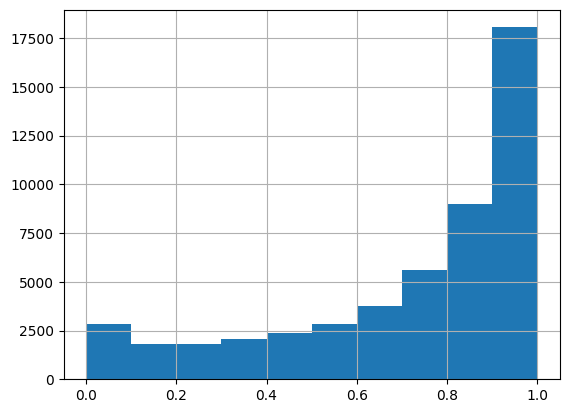

In [76]:
df_iedb_human_preds["model_pred_hum"].hist();

In [77]:
# "E:\Stuff\Research\datasets\New Protein-Virus anom project\iedb_vir_epitopes.csv.zip.csv"
df_iedb_vir = pd.read_csv("iedb_vir_epitopes.csv",compression="zip").drop_duplicates(subset=["Epitopes - Epitope"])
## raw - 138K seqs
print(df_iedb_vir.nunique())
# df_iedb_vir

df_iedb_vir = df_iedb_vir.loc[df_iedb_vir[['Epitopes - # References','Epitopes - # Assays']].max(axis=1)>1]
print(df_iedb_vir.shape[0])
df_iedb_vir = df_iedb_vir.loc[~df_iedb_vir["Epitopes - Epitope"].str.contains("[\+ ]")]
print(df_iedb_human.shape[0])

Epitopes - IEDB ID         138074
Epitopes - Epitope         138074
Epitopes - Antigen            844
Epitopes - Organism           182
Epitopes - # References        59
Epitopes - # Assays           103
dtype: int64
58544
416466


In [78]:
df_iedb_vir_preds = get_escaper_scores(df_iedb_vir.sample(50_183).copy(),trained_model=model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)
df_iedb_vir_preds

       Epitopes - IEDB ID  Epitopes - # References  Epitopes - # Assays  \
count           50183.000                50183.000            50183.000   
mean          1018706.387                    1.725                3.744   
std            735345.206                    3.346                7.547   
min                24.000                    1.000                2.000   
25%            128499.500                    1.000                2.000   
50%           1421182.000                    1.000                2.000   
75%           1638948.500                    2.000                4.000   
max           2253124.000                  352.000              869.000   

       base_pred_vir  model_pred_vir  model_pred_hum  model_pred_hum_delta  
count      50183.000       50183.000       50183.000             50183.000  
mean           0.512           0.399           0.601                -0.332  
std            0.004           0.329           0.329                 0.329  
min            0

,Epitopes - IEDB ID,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Epitopes - IEDB ID,1.000,-0.191,-0.177,-0.095,0.002,-0.002,-0.002
Epitopes - # References,-0.191,1.000,0.857,0.028,-0.012,0.012,0.012
Epitopes - # Assays,-0.177,0.857,1.000,0.018,0.004,-0.004,-0.004
base_pred_vir,-0.095,0.028,0.018,1.000,-0.140,0.140,0.140
model_pred_vir,0.002,-0.012,0.004,-0.140,1.000,-1.000,-1.000
model_pred_hum,-0.002,0.012,-0.004,0.140,-1.000,1.000,1.000
model_pred_hum_delta,-0.002,0.012,-0.004,0.140,-1.000,1.000,1.000


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
98018,1542217,QVVDADSKIVQLSEI,Replicase polyprotein 1ab,SARS-CoV2,3,6,0.516458,0.098773,0.901227,-0.0322
7313,34144,KVNSTLEQY,Replicase polyprotein 1ab,SARS-CoV1,1,4,0.517998,0.085099,0.914901,-0.0185
102134,1638757,KKEISNMLSIINKRK,Genome polyprotein,NaN,1,3,0.517632,0.984336,0.015664,-0.9177
23953,92534,EEVPNIIHEA,Pre-glycoprotein polyprotein GP complex,Mammarenavirus brazilense (Brazilian mammarena...,1,2,0.513524,0.137532,0.862468,-0.0709
64442,1425395,DVVSIRSSNQGN,Non-structural protein ORF4b,Middle East respiratory syndrome-related coron...,1,2,0.513790,0.426560,0.573440,-0.3600
...,...,...,...,...,...,...,...,...,...,...
127865,1711438,YYDDSQYYFNKDTGVI,Hemagglutinin-esterase,Betacoronavirus 1,1,2,0.500488,0.981875,0.018125,-0.9153
125757,1704459,VLSVDSVSEESQGNVV,ORF1ab polyprotein,Human coronavirus HKU1 (CoV-HKU1),1,2,0.516535,0.071591,0.928409,-0.0050
2298,11611,EEFCDMLRL,Pre-glycoprotein polyprotein GP complex,Mammarenavirus choriomeningitidis (Lymphocytic...,2,2,0.517114,0.614625,0.385375,-0.5480
35480,190297,NILDRIITNAGTCTVSIG,Major core protein 4a precursor,Vaccinia virus (vaccinia virus VV),1,2,0.508239,0.890294,0.109706,-0.8237


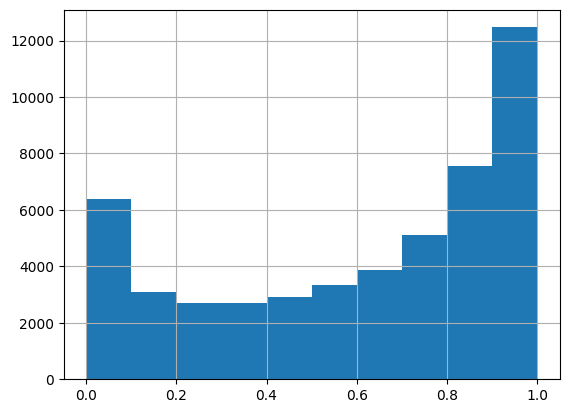

In [79]:
df_iedb_vir_preds["model_pred_hum"].hist();

In [80]:
df_iedb_vir_preds["label"]="vir"
df_iedb_human_preds["label"]="hum"

In [81]:
df_iedbs = pd.concat([df_iedb_vir_preds[["label","model_pred_hum"]],df_iedb_human_preds[["label","model_pred_hum"]]])
df_iedbs

,label,model_pred_hum
98018,vir,0.901227
7313,vir,0.914901
102134,vir,0.015664
23953,vir,0.862468
64442,vir,0.573440
...,...,...
45315,hum,0.129843
257921,hum,0.702122
298970,hum,0.159217
195819,hum,0.147555


<Axes: xlabel='model_pred_hum', ylabel='Density'>

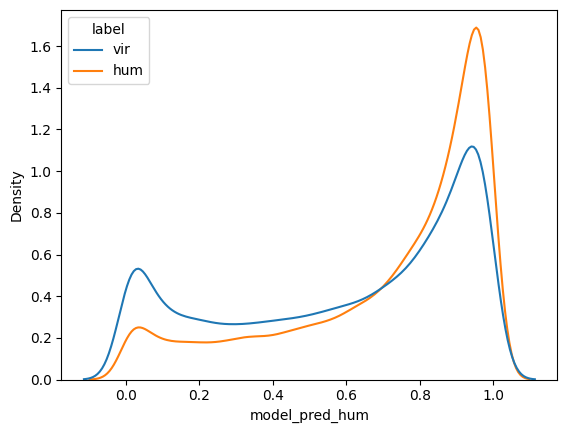

In [90]:
import seaborn as sns
# https://stackoverflow.com/questions/28293028/plotting-grouped-data-in-same-plot-using-pandas
# df_iedbs.groupby(["label"]).plot(kind='kde', ax=plt.gca())

sns.kdeplot(data=df_iedbs, x="model_pred_hum", hue="label")#, bw_adjust=1, cut=1)

In [93]:
df_iedbs.groupby("label").describe().round(2)

model_pred_hum                                        
               count  mean   std  min   25%   50%   75%  max
label                                                       
hum          50123.0  0.71  0.28  0.0  0.56  0.83  0.94  1.0
vir          50183.0  0.60  0.33  0.0  0.31  0.70  0.90  1.0